In [52]:
import torch
from torch import nn, optim
import json
import string
import random
from tqdm.auto import tqdm, trange

c:\Users\saegl\miniconda3\envs\dinora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
with open('dialogues/data/test.json') as f:
    test_data = list(json.load(f).values())

characters = set()

for entry in test_data:
    for turns in entry['turns']:
        for char in turns:
            characters.add(char)


extra_letters = ' !?"\'#$%,-./0123456789:;’'
message_start_marker = '>'
all_letters = string.ascii_letters + extra_letters + message_start_marker
n_letters = len(all_letters)

if characters.difference(all_letters):
    raise ValueError("Encoder vocabulary is smaller than dataset vocabulary")

random_entry = random.choice(test_data)
random.choice(test_data)

{'context': 'Riley had their arms raised for most of the concert, but lowered them toward the end.',
 'speaker': 'Riley',
 'turns': ['I had my arms raise for most of the concert.',
  'Really, how long was the concert?.',
  'About four hours, but I dropped my arms around three hours in.',
  "I can't say I'm shocked, that's too long to have your arms up.",
  "Yeah it wasn't my smartest move, really fun though!",
  'It sounds it!']}

In [32]:
# Let's convert json entry -> text (string) -> tensor

## json -> text
def entry_to_text(entry) -> str:
    return "".join([message_start_marker + t for t in entry['turns']])

## text -> tensor

### index to character
idx_to_chr = all_letters

### character to index
chr_to_idx = {v: k for k, v in enumerate(all_letters)}

one_hot_matrix = torch.eye(n_letters)

def text_to_tensor(text: str) -> torch.Tensor:
    output = []
    for c in text:
        index = chr_to_idx[c]
        one_hot_entry = one_hot_matrix[index]
        output.append(one_hot_entry)

    return torch.stack(output)


def entry_to_input_tensor(entry) -> torch.Tensor:  # shape (len(text), 78)
    text = entry_to_text(entry)
    return text_to_tensor(text)

def entry_to_target_tensor(entry) -> torch.Tensor:  # shape (len(text),)
    text = entry_to_text(entry)
    text = text[1:] + message_start_marker  # start_marker is also end marker :-|
    return torch.tensor([chr_to_idx[c] for c in text])



t = entry_to_input_tensor(random_entry)
print(t)
print(t.shape)


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([213, 78])


In [33]:
def get_random_entry_from_dataset() -> torch.Tensor:
    entry = random.choice(test_data)
    input_tensor = entry_to_input_tensor(entry)
    target_tensor = entry_to_target_tensor(entry)
    return input_tensor, target_tensor

input_tensor, target_tensor = get_random_entry_from_dataset()
print(input_tensor.shape)
print(target_tensor.shape)

torch.Size([244, 78])
torch.Size([244])


In [34]:
class CharGenRNN(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            batch_first,
            bidirectional,
            output_size) -> None:
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=bidirectional,
        )
        self.o2o = nn.Linear(hidden_size, output_size)  ####
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        # out shape: (seq, hidden_size)
        out = self.o2o(out)
        out = self.softmax(out)
        return out, hidden

In [56]:
input_size = n_letters
hidden_size = 256
num_layers = 6
batch_first = True
batch_size = 1
bidirectional = False
n_iters = 4_000

loss_save_freq = 100
loss_print_freq = 500

model = CharGenRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=batch_first,
    bidirectional=bidirectional,
    output_size=n_letters,
)


loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Trainig step

h0 = torch.zeros(
    num_layers,
    hidden_size,
)

all_losses = []


for i in trange(n_iters):
    input_tensor,       target_tensor = get_random_entry_from_dataset()
    # (len(text), 78),  (len(text),)

    pred,               hn = model(input_tensor, h0)
    # (seq, n_letters), ???

    loss = loss_fn(pred, target_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % loss_save_freq == 0:
        all_losses.append(loss.item())

    if i % loss_print_freq == 0:
        tqdm.write(f"{loss.item()}")


  0%|          | 2/4000 [00:00<08:13,  8.10it/s]

4.359236240386963


 13%|█▎        | 502/4000 [01:25<09:32,  6.11it/s]

3.1231815814971924


 25%|██▌       | 1002/4000 [02:51<09:38,  5.18it/s]

3.0204927921295166


 38%|███▊      | 1502/4000 [04:23<07:00,  5.94it/s]

3.140648603439331


 50%|█████     | 2001/4000 [05:58<06:11,  5.38it/s]

3.0677576065063477


 63%|██████▎   | 2502/4000 [07:33<04:21,  5.72it/s]

2.9589085578918457


 75%|███████▌  | 3001/4000 [09:02<02:46,  5.99it/s]

3.060117244720459


 88%|████████▊ | 3501/4000 [10:33<01:51,  4.49it/s]

3.0867297649383545


100%|██████████| 4000/4000 [12:05<00:00,  5.52it/s]


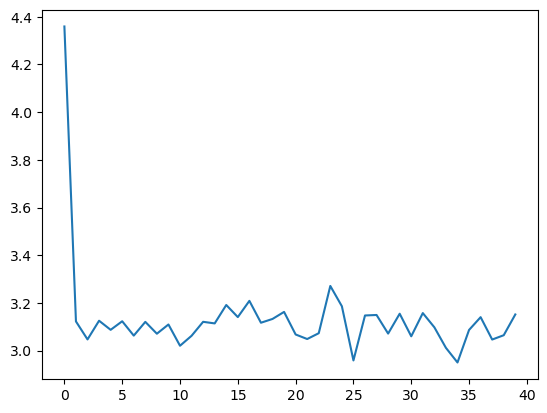

In [57]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [67]:
with torch.no_grad():  # no need to track history in sampling
    # input = inputTensor(start_letter)

    question = 'How are you?'
    input_tensor = entry_to_input_tensor({'turns': [question, '']})
    hidden = torch.zeros(
        num_layers,
        hidden_size,
    )

    output, hidden = model(input_tensor, hidden)

    output_name = message_start_marker

    for i in range(250):
        output, hidden = model(input_tensor[0].reshape(1, 78), hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi.item()]
            output_name += letter
            print("Letter", letter)
            print("Idx:", topi)
        input = entry_to_input_tensor({'turns': [letter]})

    print(output_name)

Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)
Letter  
Idx: tensor(52)


KeyboardInterrupt: 

In [65]:
all_letters[52]

' '